In [108]:
import os
import sys
import argparse
import uuid
import io
import random
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import imageio
import json
import pprint
import pathlib
from tqdm import tqdm
import colored_traceback
colored_traceback.add_hook()

import torch

import robosuite as suite
from robosuite.wrappers import GymWrapper
suite.macros.IMAGE_CONVENTION = "opencv"    # Set the image convention to opencv so the images are automatically rendered "right side up" when using imageio (which uses opencv convention)

from human_policy import ReachPolicy, BaseHumanPolicy, LiftPolicy, PickPlacePolicy
# from gym_wrapper import GymWrapper

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print("Number of GPU devices:", torch.cuda.device_count())
    print("GPU device name:", torch.cuda.get_device_name(0))
else:
    print("Device:", device)

Device: cpu


In [110]:
class AttrDict(dict):
    """
    This class allows you to access python dictionary elements using dot 
    notation `obj.key` instead of the usual square brackets `obj['key']`.
    """
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__

In [111]:
def args_type(default):
    if isinstance(default, bool):
        return lambda x: bool(['False', 'True'].index(x))
    if isinstance(default, int):
        return lambda x: float(x) if ('e' in x or '.' in x) else int(x)
    if isinstance(default, pathlib.Path):
        return lambda x: pathlib.Path(x).expanduser()
    return type(default)

In [113]:
def define_config():
    config = AttrDict()

    config.env_name = "Lift"    # "PickPlaceBread"
    config.robots = "Panda"    # "Sawyer", "UR5e"
    config.controller = "OSC_POSE"

    config.camera_names = "frontview"
    # config.camera_names = ["frontview", "agentview", "robot0_eye_in_hand"]

    config.use_camera_obs = True
    config.use_depth_obs = True
    config.use_object_obs = True
    config.use_proprio_obs = True
    config.use_touch_obs = True
    config.use_tactile_obs = False
    config.use_shape_obs = False

    config.img_width = 256
    config.img_height = 256
    config.horizon = 100
    
    return config

In [114]:
def random_policy(env, obs=None):
    low, high = env.action_spec
    action = np.random.uniform(low, high)
    return action

In [115]:
def create_env(config, verbose=False):
    assert isinstance(config.controller, str), "controller must be a str"
    if config.controller == "robomimic":
        with open("controller_config/robomimic.json", 'r') as f:
            controller_config = json.load(f)
    elif config.controller is not None:
        # load default controller parameters for Operational Space Control (OSC)
        # Only OSC_POSE controller is available for human expert
        controller_config = suite.controllers.load_controller_config(default_controller=config.controller)
    else:
        controller_config = None

    # create an environment to visualize on-screen
    env = suite.make(
        env_name=config.env_name,
        robots=config.robots,
        gripper_types="default",
        controller_configs=controller_config,
        reward_shaping=True, 
        has_renderer=False,
        has_offscreen_renderer=True,
        control_freq=20,
        horizon=config.horizon,
        use_object_obs=config.use_object_obs,
        use_camera_obs=config.use_camera_obs,
        camera_depths=config.use_depth_obs,
        camera_heights=config.img_height, 
        camera_widths=config.img_width, 
        camera_names=config.camera_names, 
        use_tactile_obs=config.use_tactile_obs,
        use_touch_obs=config.use_touch_obs
    )
    # env._max_episode_steps = env.horizon
    print(f"Environment created")

    if verbose:
        obs = env.reset()    # reset the env
        for idx, (key, val) in enumerate(obs.items()):
            print(f"{idx} Var: {key}, shape: {val.shape}, range: ({val.min()}, {val.max()})")

    return env

In [116]:
def save_frames_to_video(frames, savepath, fps=30, verbose=False):
    if not str(savepath).endswith(".mp4"):
        print("Error: savepath must have extension '.mp4'")
        return False

    with imageio.get_writer(savepath, fps=fps) as writer:
        for i in range(len(frames)):
            # frame = np.array(Image.fromarray(frames[i]).resize((512, 512)))
            writer.append_data(frames[i])
    # imageio.mimsave(savepath, frames_depth, fps=30)

    if verbose:
        print(f"Saved frames to video at {savepath}")

    return True

In [117]:
def episode_rollout(env, config, save_frames=False):
    """
    Rolls out an episode using some policy and saves RGB + depth (maybe) 
    frames in a video
    """
    if isinstance(config.camera_names, str):
        rgb_cam = config.camera_names + "_image"
        depth_cam = config.camera_names + "_depth"
    elif isinstance(config.camera_names, list):
        rgb_cam = [camera_name + "_image" for camera_name in config.camera_names]
        depth_cam = [camera_name + "_depth" for camera_name in config.camera_names]

    obs = env.reset()    # reset the env

    rgb_frames = [obs[rgb_cam]]
    depth_frames = [np.uint8(obs[depth_cam] * 255)]

    ep_reward = 0
    start_time = time.time()

    # episode rollout
    done = False
    while not done:
        action = random_policy(env)         # use observation to decide on an action
        obs, reward, done, _ = env.step(action)    # play action
        ep_reward += reward

        rgb_frames.append(obs[rgb_cam])
        depth_image = np.uint8(obs[depth_cam] * 255)
        depth_frames.append(depth_image)

        # proprio_state = np.concatenate((obs["robot0_joint_pos_cos"], obs["robot0_joint_pos_sin"], obs["robot0_joint_vel"], obs["robot0_eef_pos"], obs["robot0_eef_quat"], obs["robot0_gripper_qpos"], obs["robot0_gripper_qvel"]))
        # proprio_err = np.sum(proprio_state - obs["robot0_proprio-state"])
        # assert proprio_err == 0, f"Proprio-state error: {proprio_err}"

        # object_state = np.concatenate((obs["cube_pos"], obs["cube_quat"], obs["cube_to_robot0_eef_pos"], obs["cube_to_robot0_eef_quat"], obs["robot0_eef_to_cube_yaw"]))
        # object_err = np.sum(object_state - obs["object-state"])
        # assert object_err == 0, f"Object-state error: {object_err}"

        # touch_err = np.sum(obs["robot0_touch"] - obs["robot0_touch-state"])
        # assert touch_err == 0, f"Object-state error: {touch_err}"
    
    print(f"rollout completed with return {ep_reward}")
    print(f"Spent {time.time() - start_time:.3f} s to rollout {config.horizon} steps")

    if save_frames:
        save_frames_to_video(rgb_frames, "../demo_videos/rgb_video.mp4")
        save_frames_to_video(depth_frames, "../demo_videos/depth_video.mp4")
    
    return rgb_frames, depth_frames

In [118]:
def load_episodes(directory, capacity=None):
    # The returned directory from filenames to episodes is guaranteed to be in
    # temporally sorted order.
    filepaths = sorted(directory.glob('*.npz'))
    if capacity:
        num_steps = 0
        num_episodes = 0
        for filename in reversed(filenames):
            length = int(str(filename).split('-')[-1][:-4])
            num_steps += length
            num_episodes += 1
            if num_steps >= capacity:
                break
        filenames = filenames[-num_episodes:]
    
    episodes = {}
    for filepath in filepaths:
        try:
            with filepath.open('rb') as f:
                episode = np.load(f)
                episode = {k: episode[k] for k in episode.keys()}
        except Exception as e:
            print(f'Could not load episode {str(filepath)}: {e}')
            continue
        episodes[str(filepath)] = episode
    return episodes

In [ ]:
def visualize_expert_episodes(dirpath, config):
    # stitch the images in an episode from expert data and store in a video for visualization
    assert dirpath, isinstance(str)
    directory = pathlib.Path(dirpath)
    episodes = load_episodes(directory)

    print(f"Loaded {len(episodes)} episodes / trajectories")
    filenames = sorted(directory.glob("*.npz"))

    print("Visualize the expert data images")
    for filename in filenames:
        episode = episodes[str(filename)]
        images = episode["agentview_image"]
        rewards = episode["reward"]
        actions = episode["action"]
        print(images.shape, images.min(), images.max())
        print(actions.shape, actions.min(), actions.max())
        # print(rewards.shape, rewards)

        video_path = "robosuite_expert_small/videos/test.mp4"
        frames = episodes[str(filename)]['agentview_image']
        break

In [119]:
def save_episode(env, dirpath, episode):
    """
    Saves an episode in a '.npz' file. Saves image observations in a video.
    """
    timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')
    identifier = str(uuid.uuid4().hex)[:8]
    
    data_dir = pathlib.Path(f"{dirpath}/episodes/")
    if not data_dir.exists():
        data_dir.mkdir(parents=True, exist_ok=False)
    filename = data_dir / f'{timestamp}-{identifier}.npz'
    
    with io.BytesIO() as f1:
        np.savez_compressed(f1, **episode)
        f1.seek(0)
        with filename.open('wb') as f2:
            f2.write(f1.read())
    
    # save the image observations in a video to verify whether the
    # task (lifting process) works correctly
    video_dir = pathlib.Path(f"{dirpath}/videos/")
    if not video_dir.exists():
        video_dir.mkdir(parents=True, exist_ok=False)

    # check whether the episode dict has any "_image" key
    img_keys = [key for key in episode.keys() if "_image" in key]
    for key in img_keys:
        frames = episode[key]
        video_path = video_dir / f"{timestamp}-{identifier}-{''.join(key.split('_')[0:-1])}.mp4"
        save_frames_to_video(frames, video_path)

    return filename

In [120]:
def sample_episodes(env, policy, dirpath, num_eps=1, policy_obs_keys=None):
    eps_rewards = []
    for _ in tqdm(range(num_eps)):
        obs = env.reset()
        if isinstance(policy, BaseHumanPolicy):
            policy.reset()

        # Save all observation keys from env
        obs_keys = list(obs.keys())
        episode = {k : [obs[k]] for k in obs_keys}
        episode['action'] = []
        episode['reward'] = []

        # rollout an episode
        done = False
        while not done:
            if policy_obs_keys is not None:
                policy_obs = np.concatenate([obs[k] for k in policy_obs_keys])
            else:
                policy_obs = obs
            action, _ = policy.predict(policy_obs)
            obs, rew, done, _ = env.step(action)
            for k in obs_keys:
                episode[k].append(obs[k])
            episode['action'].append(action)
            episode['reward'].append(rew)

        print(f"Episode total reward: {np.sum(episode['reward']):.2f}")
        eps_rewards.append(np.sum(episode['reward']))
        save_episode(env, dirpath, episode)
        # if np.sum(episode['reward']) < 160:
        #     print("Discarding current episode")
        #     continue
        # else:
        #     save_episode(env, directory, episode)
        #     episodes_saved += 1
    
    # plot episode total rewards
    plt.figure()
    plt.plot(eps_rewards)
    plt.axhline(y=env.horizon, color='r', linestyle='-')
    plt.gca().set_ylim([0, env.horizon+20])
    plt.gca().set_xlim([0, len(eps_rewards)])
    plt.xlabel("Episodes")
    plt.ylabel("Episode Reward")
    plt.grid(linestyle="--")
    savepath = dirpath / f'reward_plot.png'
    plt.savefig(savepath)

In [91]:
# def save_human_episodes(env, config):
    # policy_obs_keys = ['target_to_robot0_eef_pos']
    # policy_obs_keys = [
    #     'robot0_eef_pos',
    #     'target_to_robot0_eef_pos',
    # ]

    # ob_encoder_params = utils.AttrDict(
    #     type='identity',
    #     input_dim=6,
    #     feature_dim=6,
    #     n_layers=3,
    #     hidden_dim=512,
    #     activation='relu',
    #     output_activation='identity',
    #     lr=3e-4,
    #     update_freq=1,
    # )
    # actor_critic_params = utils.AttrDict(
    #     lr=3e-4, 
    #     n_layers=3, 
    #     hidden_dim=512,
    #     update_freq=2,
    #     tau=0.005,
    # )
    # disc_params = utils.AttrDict(
    #     reward_type=None, 
    #     n_layers=3,
    #     hidden_dim=256,
    #     activation='relu',
    #     spectral_norm=True,
    #     lr=3e-5,
    #     update_freq=1,
    # )

    # policy = SacAeAgent(
    #     (6,),
    #     (7,),
    #     device=device,
    #     ob_encoder_params=ob_encoder_params,
    #     actor_critic_params=actor_critic_params,
    #     disc_params=disc_params,
    # )
    # model_dir = "./data/05.01.2023/14-42-59_Reach_OSC_POSE_SAC_OSC/models/step_0050000"
    # policy.load(model_dir)

Environment created
0 Var: robot0_joint_pos_cos, shape: (7,), range: (-0.9795183375993073, 0.9998997505708214)
1 Var: robot0_joint_pos_sin, shape: (7,), range: (-0.5045060898720324, 0.7127009655705244)
2 Var: robot0_joint_vel, shape: (7,), range: (0.0, 0.0)
3 Var: robot0_eef_pos, shape: (3,), range: (-0.09727139055778301, 1.0193160306752398)
4 Var: robot0_eef_quat, shape: (4,), range: (-0.0066152737499190995, 0.9973423368536467)
5 Var: robot0_gripper_qpos, shape: (2,), range: (-0.020833, 0.020833)
6 Var: robot0_gripper_qvel, shape: (2,), range: (0.0, 0.0)
7 Var: frontview_image, shape: (256, 256, 3), range: (6, 255)
8 Var: frontview_depth, shape: (256, 256, 1), range: (0.9920311570167542, 0.9972583055496216)
9 Var: robot0_touch, shape: (2,), range: (0.0, 0.0)
10 Var: cube_pos, shape: (3,), range: (-0.027427550635656113, 0.8306710214016695)
11 Var: cube_quat, shape: (4,), range: (-0.9995560579423162, 0.029794077109670497)
12 Var: cube_to_robot0_eef_pos, shape: (3,), range: (-0.069843839

  0%|          | 0/64 [00:00<?, ?it/s]

Episode total reward: 34.41


  2%|▏         | 1/64 [00:05<06:05,  5.80s/it]

Episode total reward: 55.16


  3%|▎         | 2/64 [00:09<04:27,  4.32s/it]

Episode total reward: 38.35


  5%|▍         | 3/64 [00:12<03:54,  3.84s/it]

Episode total reward: 34.75


  6%|▋         | 4/64 [00:15<03:37,  3.63s/it]

Episode total reward: 71.03


  8%|▊         | 5/64 [00:18<03:26,  3.51s/it]

Episode total reward: 40.04


  9%|▉         | 6/64 [00:22<03:19,  3.43s/it]

Episode total reward: 26.87


 11%|█         | 7/64 [00:25<03:13,  3.39s/it]

Episode total reward: 68.20


 12%|█▎        | 8/64 [00:28<03:07,  3.35s/it]

Episode total reward: 54.90


 14%|█▍        | 9/64 [00:32<03:03,  3.33s/it]

Episode total reward: 29.40


 16%|█▌        | 10/64 [00:35<02:59,  3.32s/it]

Episode total reward: 39.24


 17%|█▋        | 11/64 [00:38<02:55,  3.31s/it]

Episode total reward: 34.18


 19%|█▉        | 12/64 [00:42<02:52,  3.33s/it]

Episode total reward: 39.01


 20%|██        | 13/64 [00:45<02:49,  3.33s/it]

Episode total reward: 37.63


 22%|██▏       | 14/64 [00:48<02:46,  3.32s/it]

Episode total reward: 38.62


 23%|██▎       | 15/64 [00:52<02:42,  3.32s/it]

Episode total reward: 40.30


 25%|██▌       | 16/64 [00:55<02:39,  3.32s/it]

Episode total reward: 46.29


 27%|██▋       | 17/64 [00:58<02:36,  3.32s/it]

Episode total reward: 27.84


 28%|██▊       | 18/64 [01:01<02:32,  3.33s/it]

Episode total reward: 27.19


 30%|██▉       | 19/64 [01:05<02:29,  3.31s/it]

Episode total reward: 66.31


 31%|███▏      | 20/64 [01:08<02:26,  3.33s/it]

Episode total reward: 60.21


 33%|███▎      | 21/64 [01:11<02:23,  3.33s/it]

Episode total reward: 45.46


 34%|███▍      | 22/64 [01:15<02:20,  3.34s/it]

Episode total reward: 43.34


 36%|███▌      | 23/64 [01:18<02:16,  3.33s/it]

Episode total reward: 56.61


 38%|███▊      | 24/64 [01:21<02:13,  3.34s/it]

Episode total reward: 42.96


 39%|███▉      | 25/64 [01:25<02:10,  3.33s/it]

Episode total reward: 26.63


 41%|████      | 26/64 [01:28<02:06,  3.32s/it]

Episode total reward: 41.49


 42%|████▏     | 27/64 [01:31<02:02,  3.31s/it]

Episode total reward: 69.92


 44%|████▍     | 28/64 [01:35<01:59,  3.33s/it]

Episode total reward: 44.37


 45%|████▌     | 29/64 [01:38<01:56,  3.32s/it]

Episode total reward: 62.82


 47%|████▋     | 30/64 [01:41<01:53,  3.33s/it]

Episode total reward: 57.34


 48%|████▊     | 31/64 [01:45<01:49,  3.32s/it]

Episode total reward: 40.49


 50%|█████     | 32/64 [01:48<01:46,  3.32s/it]

Episode total reward: 50.24


 52%|█████▏    | 33/64 [01:51<01:42,  3.31s/it]

Episode total reward: 71.95


 53%|█████▎    | 34/64 [01:55<01:39,  3.31s/it]

Episode total reward: 38.70


 55%|█████▍    | 35/64 [01:58<01:36,  3.33s/it]

Episode total reward: 59.08


 56%|█████▋    | 36/64 [02:01<01:33,  3.33s/it]

Episode total reward: 40.53


 58%|█████▊    | 37/64 [02:05<01:29,  3.33s/it]

Episode total reward: 71.13


 59%|█████▉    | 38/64 [02:08<01:26,  3.32s/it]

Episode total reward: 45.07


 61%|██████    | 39/64 [02:11<01:22,  3.32s/it]

Episode total reward: 42.64


 62%|██████▎   | 40/64 [02:15<01:19,  3.30s/it]

Episode total reward: 52.33


 64%|██████▍   | 41/64 [02:18<01:16,  3.31s/it]

Episode total reward: 68.78


 66%|██████▌   | 42/64 [02:21<01:12,  3.31s/it]

Episode total reward: 37.82


 67%|██████▋   | 43/64 [02:24<01:09,  3.31s/it]

Episode total reward: 33.84


 69%|██████▉   | 44/64 [02:28<01:06,  3.33s/it]

Episode total reward: 70.02


 70%|███████   | 45/64 [02:31<01:03,  3.36s/it]

Episode total reward: 39.41


 72%|███████▏  | 46/64 [02:35<01:00,  3.37s/it]

Episode total reward: 35.39


 73%|███████▎  | 47/64 [02:38<00:57,  3.38s/it]

Episode total reward: 63.27


 75%|███████▌  | 48/64 [02:42<00:54,  3.40s/it]

Episode total reward: 57.14


 77%|███████▋  | 49/64 [02:45<00:51,  3.44s/it]

Episode total reward: 60.89


 78%|███████▊  | 50/64 [02:49<00:48,  3.47s/it]

Episode total reward: 54.50


 80%|███████▉  | 51/64 [02:52<00:45,  3.49s/it]

Episode total reward: 33.47


 81%|████████▏ | 52/64 [02:56<00:41,  3.50s/it]

Episode total reward: 27.53


 83%|████████▎ | 53/64 [02:59<00:38,  3.47s/it]

Episode total reward: 64.44


 84%|████████▍ | 54/64 [03:02<00:34,  3.46s/it]

Episode total reward: 44.37


 86%|████████▌ | 55/64 [03:06<00:31,  3.45s/it]

Episode total reward: 72.02


 88%|████████▊ | 56/64 [03:09<00:27,  3.46s/it]

Episode total reward: 68.00


 89%|████████▉ | 57/64 [03:13<00:24,  3.47s/it]

Episode total reward: 47.19


 91%|█████████ | 58/64 [03:16<00:20,  3.47s/it]

Episode total reward: 36.99


 92%|█████████▏| 59/64 [03:20<00:17,  3.47s/it]

Episode total reward: 56.89


 94%|█████████▍| 60/64 [03:23<00:13,  3.49s/it]

Episode total reward: 55.20


 95%|█████████▌| 61/64 [03:27<00:10,  3.53s/it]

Episode total reward: 51.74


 97%|█████████▋| 62/64 [03:31<00:07,  3.54s/it]

Episode total reward: 54.11


 98%|█████████▊| 63/64 [03:34<00:03,  3.54s/it]

Episode total reward: 40.57


100%|██████████| 64/64 [03:38<00:00,  3.41s/it]


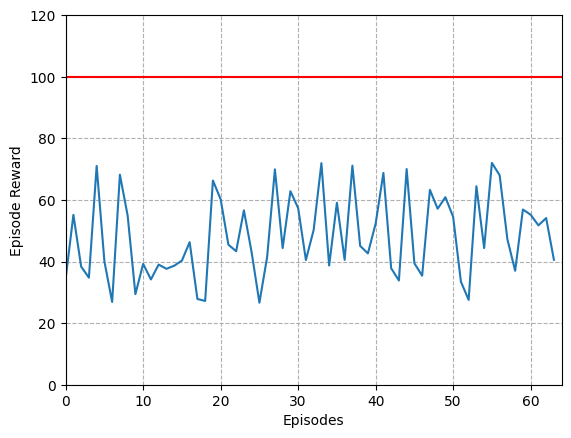

In [121]:
config = define_config()
env = create_env(config, verbose=True)

if config.env_name == "Lift":
    policy = LiftPolicy(env)
elif config.env_name == "Reach":
    policy = ReachPolicy(env)
elif config.env_name == "PickPlaceBread":
    policy = PickPlacePolicy(env)
print("Policy object created")

timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')
dirpath = pathlib.Path(f"../expert_data/robosuite/{config.env_name.lower()}/{config.robots.lower()}/{config.controller.lower()}/{timestamp}-{config.horizon}/")
print("Store directory:", dirpath)
if not dirpath.exists():
    dirpath.mkdir(parents=True, exist_ok=True)

# generate episodes based on policy and save episodes and videos
sample_episodes(env, policy, dirpath, num_eps=64, policy_obs_keys=None)

env.close()